# Anàlisi de sentiments
    
En este documento trataremos 4 temas.

1. **Detección de elementos de opiniones**: Identificación de targets, aspectos y opiniones words.
2. **Detección de polaridad**: Extracción de polaridades de las opiniones.
3. **Clasificación**: clasificación de opiniones.
4. **Evaluación**: comparación de modelos.

# 1. Detección de elementos de opiniones

En este apartado aplicaremos los conocimientos aprendidos sobre la detección de targets y aspectos en opiniones.

Primero, cargamos los paquetes necesarios y los datos.

In [1]:
pip install wget

In [1]:
import pandas as pd
import gensim
import nltk
import re
nltk.download('punkt')
import os
import wget
import gzip
import shutil
from nltk import pos_tag, word_tokenize
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Casa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Casa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
hotel_opinions_data = pd.read_csv('hotel_opinions_data.csv')
hotel_opinions_data.head()

Hotel_Address  \
0  3 Boulevard Saint Michel 5th arr 75005 Paris F...   
1  Wrights Lane Kensington and Chelsea London W8 ...   
2  Via Tarchetti 2 Milan City Center 20121 Milan ...   
3  Avinguda Catedral 7 Ciutat Vella 08002 Barcelo...   
4  Wrights Lane Kensington and Chelsea London W8 ...   

   Additional_Number_of_Scoring Review_Date  Average_Score  \
0                           120  10/25/2015            8.0   
1                          1172   8/27/2015            7.8   
2                           436   9/18/2016            8.4   
3                           170   2/16/2016            8.9   
4                          1172    6/5/2016            7.8   

                      Hotel_Name reviewer_nationality  \
0             Royal Saint Michel             Lebanon    
1  Holiday Inn London Kensington           Australia    
2              NH Milano Touring               Qatar    
3          Col n Hotel Barcelona             Ireland    
4  Holiday Inn London Kensington      United Kingdom    

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                  3                     1193   
1                                 18                     5945   
2                                 24                     4568   
3                                  3                     1300   
4                                 45                     5945   

   Review_Total_Positive_Word_Counts  \
0                                  0   
1                                 56   
2                                  6   
3                                 37   
4                                 12   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           1             9.6   
1                                           2             9.6   
2                                           2             7.1   
3                                           3             9.2   
4                                          12             8.8   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Group ', ' Double Room ',...           648 day   
1  [' Leisure trip ', ' Solo traveler ', ' Execut...           707 day   
2  [' Leisure trip ', ' Family with young childre...           319 day   
3  [' Leisure trip ', ' Couple ', ' Standard Doub...           534 day   
4  [' Leisure trip ', ' Group ', ' 2 rooms ', ' S...           424 day   

         lat       lng                                             review  
0  48.852836  2.344080                            l ascenseur No Positive  
1  51.499981 -0.192879   Having to log in each day with a new login an...  
2  45.476917  9.196665   the TV is crazy the hotel host a lot of natio...  
3  41.384961  2.175667   No complaints  Excellent location very helpfu...  
4  51.499981 -0.192879   We booked an executive room with super king b...

In [4]:
# Creamos una nueva etiqueta donde agrupamos por reviews buenas o malas

hotel_opinions_data["sentiment"] = hotel_opinions_data["Reviewer_Score"].apply(lambda x: "good" if x < 5 else "bad")

# Seleccionamos las columnas más relevantes

hotel_opinions_data = hotel_opinions_data[["review","reviewer_nationality", "sentiment"]]
hotel_opinions_data.head()

review reviewer_nationality  \
0                            l ascenseur No Positive             Lebanon    
1   Having to log in each day with a new login an...           Australia    
2   the TV is crazy the hotel host a lot of natio...               Qatar    
3   No complaints  Excellent location very helpfu...             Ireland    
4   We booked an executive room with super king b...      United Kingdom    

  sentiment  
0       bad  
1       bad  
2       bad  
3       bad  
4       bad

Descargamos el modelo Word2Vec de Google News dataset, con aproximadamente 3 millones de palabras.

https://github.com/eyaler/word2vec-slim/blob/master/GoogleNews-vectors-negative300-SLIM.bin.gz

En ese caso para que no nos dé un fallo de memoria RAM utilizaremos 500 mil palabras del modelo.

In [5]:
from gensim.models import KeyedVectors

wv = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300-SLIM.bin.gz', binary=True, limit=500000) 

Convertimos los comentarios en un solo texto en minúscula

In [6]:
comment_text = " ".join(hotel_opinions_data['review'].to_list()).lower()

print(comment_text[:100])

 l ascenseur no positive  having to log in each day with a new login and password to use the wifi   


Obtendremos los sintagmas nominales de los comentarios. Los sintagmas nominales serán los candidatos a ser los targets y aspectos de las opiniones

## Ejercicio 1

**Obtener las phrases del texto de comentarios usando el modelo adjuntado al ejercicio (modelo_phrases)**

Primero importamos las librerías necesarias.

In [7]:
from gensim.models.phrases import Phrases

Ahora cargamos el modelo ya creado.

In [8]:
model_phrases = Phrases.load("model_phrases")

# Comprobamos
type(model_phrases)

gensim.models.phrases.Phrases

Con este modelo obtenemos las phrases de forma similar a como lo hemos hecho en la anterior práctica. Primero conseguimos los tokens de los comentarios y después aplicamos el modelo.

In [9]:
tokens = word_tokenize(comment_text.lower())
phrases = model_phrases[tokens]

# Comprobamos
phrases[0:10]

['l',
 'ascenseur',
 'no',
 'positive',
 'having_to',
 'log',
 'in',
 'each',
 'day',
 'with_a']

**Las phrases pueden contener sintagmas nominales (e.g: at_night). La función <i>get_np</i> sirve para quitar el sintagma nominal de la phrase (e.g: at_night -> night). Explica el código de la función <i>get_np</i> que se define más abajo**

In [11]:
def get_np(candidate):
    np = ''
    tokens = candidate.split('_')
    tagged_tokens = pos_tag((tokens))
    PoS_initial = tagged_tokens[0][1][:2]
    PoS_final = tagged_tokens[-1][1][:2]
    if PoS_initial == 'NN':
        if len(tagged_tokens) > 1:
            if PoS_final == 'NN':
                np = candidate
            else:
                np = tokens[0]
        else:
            np = candidate
    else:
        if PoS_final == 'NN':
            np = tokens[-1]
    return np

<b>Explicamos la función</b>

La función get_np recibirá como argumento una de las *prhases* que hemos obtenido y realiza el siguiente tratamiento:
1. Separa la *phrase* por el carácter '_'.
2. Luego etiqueta las dos posibles partes de la división y almacena el tipo de sintagma en las variables PoS_initial* y PoS_final*.
3. Ahora comprueba si estos sintagmas son sintagmas nominales. Si tanto la etiqueta inicial como final son 'NN', devuelve la *prhase* completa. Si sólo uno de los dos es un sintagma nominal, volverá sólo esa parte de la *phrase*. Si ninguno de los dos lo es, devolverá una cadena vacía.

No hay ningún problema si la *phrase* que le pasamos no contiene el carácter '_'. En este caso tanto el *PoS_initial* como *PoS_final* tendrán el mismo valor porque estarán haciendo referencia al único token.

**Ahora extraemos los sintagmas nominales de las phrases con la función get_np. Así obtendremos todos los candidatos a target y aspecto a las opiniones.**

Aplicamos la función para cada phrase* que hemos obtenido y almacenamos en una variable sólo aquellas que son sintagmas nominales.

In [12]:
phrases_nom = [get_np(c) for c in phrases if len(get_np(c)) > 0]

# Comprobamos
phrases_nom[0:10]

['l',
 'ascenseur',
 'log',
 'day',
 'login',
 'password',
 'wifi',
 'kensington',
 'hotel',
 'location']

Por curiosidad podemos ver el total de phrases* que teníamos antes y después de aplicar este filtro.

In [13]:
print(len(phrases))
print(len(phrases_nom))

38215
14584


Por último, los guardamos en un archivo llamado NPs_COMMENTS.txt.

In [14]:
with open('NPs_COMMENTS.txt', 'w') as f:
    [f.write(nom + '\n') for nom in phrases_nom]

Cargamos los sintagmas nominales de los comentarios que ha guardado en un archivo. Por ejemplo, en un archivo llamado 'NPs_COMMENTS.txt'

In [16]:
with open('NPs_COMMENTS.txt') as nf:
     nps_comments = nf.read().split('\n')

In [17]:
# Comprobamos
nps_comments[0:10]

['l',
 'ascenseur',
 'log',
 'day',
 'login',
 'password',
 'wifi',
 'kensington',
 'hotel',
 'location']

## Ejercicio 2

**Obtener targets que están en las opiniones. Para obtenerlos, encontraremos los 100 sintagmas nominales más parecidos al término <i>hotel</i> según el modelo Word2Vec de Google News que también existen las opiniones**


Para obtener estos 100 sintagmas aplicaremos el modelo Word2Vec de Google de forma similar a cómo aplicamos un modelo creado por nosotros en el documento "Procesamiento y análisis de información textual.ipynb". Reutilizaremos la función adaptándola a nuestras necesidades.

In [18]:
def get_similarity_distance(word,vocabulary,model):
    
    # Variable donde se almacenarán todas las tuplas [término, valor similitud]
    w2v_tuples = []

    # Para cada término del vocabulario se calcula la distancia.
    # Si es mayor a 0, se añade a la variable anterior           
    for term in vocabulary:
        if term != word and model.similarity(word, term) > 0:
            w2v_tuples.append((term, model.similarity(word, term)))
    
    # Devolvemos la lista ordenada por el valor
    return sorted(w2v_tuples, key=lambda tup: tup[1], reverse=True)

Obtenemos el vocabulario de los términos filtrando aquellos sintagmas nominales que estén en el vocabulario del modelo Word2Vec de Google. Aquellos términos que no estén en este modelo serán descartados.

Aplicamos set() para quedarnos en los términos únicos y no tener palabras repetidas en el vocabulario.

In [19]:
vocabulary_comments = set([term for term in nps_comments if term in wv.vocab])

# Comprobamos
print(len(vocabulary_comments))
list(vocabulary_comments)[0:5]

2437


['meat', 'ibis', 'passwords', 'unfortunate', 'taps']

Ahora ya podemos utilizar la función y quedarnos con los 100 sintagmas más similares.

In [20]:
sn_100_google_hotel = get_similarity_distance('hotel',set(vocabulary_comments),wv)[0:100]

# Comprobamos
print(len(sn_100_google_hotel))
sn_100_google_hotel[0:5]

100


[('hotels', 0.77097285),
 ('motel', 0.66171205),
 ('restaurant', 0.57237756),
 ('inn', 0.5590306),
 ('apartment', 0.5006557)]

**También obtendremos los targets calculando los sintagmas nominales de las opiniones que son más cercanos al synset hotel.n.01, según la distancia de Wu y Palmer. Para calcular la proximidad de un sintagma nominal, coge el synset de su primera acepción (e.g: 'dog.n.01'). Ver los 50 synsets más cercanos**

Cargamos las librerías necesarias.

In [21]:
from nltk.corpus import wordnet

Como en los anteriores ejercicios, seguiremos el mismo procedimiento que hemos realizado en la primera práctica. Reutilizaremos parte del código para calcular todos los *synsets* de los sintagmas nominales únicos y después nos quedaremos con los 50 más cercanos.

Primero obtenemos los sintagmas nominales únicos.

In [22]:
terms_unique = set(nps_comments)

# Comprobamos
print(len(terms_unique))

2749


Ahora recorremos estos términos y almacenamos los "synsets".

In [23]:
hotel = wordnet.synset('hotel.n.01')
all_synsets = []
for term in terms_unique:
    synsets = wordnet.synsets(term)
    if len(synsets) > 0:
        all_synsets.append((term, hotel.wup_similarity(synsets[0])))

# Comprobamos
print(len(all_synsets))
all_synsets[0:5]

2369


[('meat', 0.2857142857142857),
 ('ibis', 0.38095238095238093),
 ('passwords', 0.13333333333333333),
 ('unfortunate', 0.5),
 ('taps', 0.14285714285714285)]

De los 2749 términos que teníamos se han encontrado *synsets* para la gran mayoría, 2369, pero ha habido algunos para los que no ha sido posible.

Guardamos ahora los 50 synsets más cercanos al synset hotel.n.01.

In [24]:
sn_50_wordnet_hotel = sorted(all_synsets, key=lambda tup: tup[1], reverse=True)[0:50]

# Comprobamos
print(len(sn_50_wordnet_hotel))
sn_50_wordnet_hotel[0:5]

50


[('hotels', 1.0),
 ('hotel', 1.0),
 ('inn', 0.9411764705882353),
 ('hostel', 0.9411764705882353),
 ('building', 0.9333333333333333)]

**Comentamos las diferencias respecto a los targets encontrados con el modelo Word2Vec. ¿El método con Wordnet tiene inconvenientes?**

Vemos los primeros 15 términos de cada uno de los métodos que hemos utilizado.

In [26]:
sn_100_google_hotel[0:15]

[('hotels', 0.77097285),
 ('motel', 0.66171205),
 ('restaurant', 0.57237756),
 ('inn', 0.5590306),
 ('apartment', 0.5006557),
 ('airport', 0.4811368),
 ('rooms', 0.4772007),
 ('hospitality', 0.47283834),
 ('spa', 0.4728283),
 ('luxury', 0.47001633),
 ('occupancy', 0.46986634),
 ('accommodation', 0.46953398),
 ('lodge', 0.46820712),
 ('room', 0.46567726),
 ('tourist', 0.46373928)]

In [27]:
sn_50_wordnet_hotel[0:15]

[('hotels', 1.0),
 ('hotel', 1.0),
 ('inn', 0.9411764705882353),
 ('hostel', 0.9411764705882353),
 ('building', 0.9333333333333333),
 ('buildings', 0.9333333333333333),
 ('motel', 0.8888888888888888),
 ('architecture', 0.875),
 ('restaurant', 0.875),
 ('house', 0.875),
 ('eateries', 0.875),
 ('restaurants', 0.875),
 ('theatre', 0.875),
 ('theatres', 0.875),
 ('cafe', 0.8235294117647058)]

Fácilmente, podemos ver que los términos más parecidos obtenidos con Wordnet se refieren mayoritariamente a edificios, en cambio, los que ha obtenido con el modelo Word2Vec de Google incluyen otros sintagmas como spa, luxury o lodge, palabras muy relacionadas con una estancia en un hotel pero que si comparamos su significado no tiene nada que ver.

In [28]:
print("Hotel:", hotel.definition())
print("Spa:", wordnet.synsets('spa')[0].definition())
print("Airport:", wordnet.synsets('airport')[0].definition())

Hotel: a building where travelers can pay for lodging and meals and other services
Spa: a health resort near a spring or at the seaside
Airport: an airfield equipped with control tower and hangars as well as accommodations for passengers and cargo


Claramente, la definición de spa y airport no hace ninguna referencia a un hotel.

Con el modelo Wordnet hemos obtenido términos muy relacionados con hotel, pero tiene el inconveniente de que no ha logrado relacionar otros términos que suelen ir asociados con un hotel como sus servicios o características y que nada tienen que ver según su definición.

Otro inconveniente de Wordnet es que puede que no encontremos ningún synset para algunos términos, tal y como se menciona en la teoría del módulo dos con el término battery_life. En nuestro caso tenemos casi 400 términos de los que no hemos obtenido ningún *synset*.

## Ejercicio 3

**Encontraremos los aspectos vinculados a los targets según el modelo Word2Vec. Lo haremos encontrando los sintagmas nominales de los comentarios más cercanos semánticamente a los targets. Los targets deben estar en forma singular y plural. Para calcular la distancia semántica lo haremos con la función <i>model_w2v.similarity</i>. Establecemos un umbral de similitud a partir del cual obtienes más aspectos introduciendo el menor ruido posible**


Importamos las librerías necesarias.

In [29]:
from nltk.stem.wordnet import WordNetLemmatizer
import inflect

Como aspectos candidatos para cada *target* obtenido según el modelo Word2Vec partiremos de la variable *vocabulary_comments* que ya tenemos definida. En esta variable habíamos conseguido los sintagmas nominales únicos de los comentarios que están en el vocabulario del modelo Word2Vec.

Para obtener los aspectos independientemente de si el target está en singular o plural utilizaremos las siguientes funciones obtenidas de **Antic** (2021).

In [30]:
def is_plural_wn(noun):
    wnl = WordNetLemmatizer()
    lemma = wnl.lemmatize(noun, 'n')
    plural = True if noun is not lemma else False
    return plural

In [31]:
def get_plural(noun):
    p = inflect.engine()
    if(is_plural_wn(noun)):
        return noun
    else:
        return p.plural(noun)

In [32]:
def get_singular(noun):
    p = inflect.engine()
    singular = p.singular_noun(noun)
    if (singular):
        return singular
    else:
        return noun

Estas funciones realizan lo siguiente:
- *is_plural_wn()*: Utiliza el objeto WordNetLemmatizer() para comprobar si un nombre es singular o plural. Devolverá True o False
- *get_plural()*: Utiliza la librería *inflect* y transforma un nombre en singular a plural. Hemos modificado la función original para incluir la comprobación de que el nombre que le pasamos ya no es un nombre en plural.
- *get_singular()*: Al igual que la función anterior, utiliza la librería *inflect* para transformar un nombre a singular si es posible, si no, devolverá la palabra que le pasamos.

Con estas funciones definiremos otra que devuelva los aspectos de cada target siempre que se supere un umbral indicado.

Para ver la puntuación de cada posible aspecto, se tendrá en cuenta la máxima puntuación de las formas plural y singular del target, siempre que sea posible. Hagamos esto para que para nuestro caso plural y singular harán referencia al mismo target.

In [33]:
def get_aspects_w2v(targets, aspects, threshold):
    # Este dicto nos servirá para almacenar los aspectos de cada target
    targets_aspects = dict()
    
    # Recorremos todos los targets
    for t in targets:
        similarities = []
        singular = get_singular(t[0])
        plural = get_plural(t[0])
        
        # Para cada target comprobamos la similitud con todos los aspectos
        for a in aspects:
            
            # Comprobamos si el singular y plural del target está en el vocabulario del modelo y calculamos la puntuación
            if(singular in wv.vocab and plural in wv.vocab):
                score = max(wv.similarity(singular, a), wv.similarity(plural, a))
            else:
                score = wv.similarity(t[0], a)
            
            # Si la similitud supera el umbral indicado, guardaremos el aspecto y la puntuación
            if score > threshold:
                similarities.append((a, score))
                
        # Guardamos los aspectos ordenados por similitud
        targets_aspects[t[0]] = sorted(similarities, key=lambda tup: tup[1], reverse=True)
        
    # Devolvemos el dicto con los targets y sus aspectos
    return targets_aspects

Empezamos calculando los términos más similares con un umbral de 0.2.

In [34]:
aspectes_02 = get_aspects_w2v(sn_100_google_hotel, vocabulary_comments, 0.2)

Para ver qué aspectos ha tomado podemos ver uno de los targets.

In [35]:
print(len(aspectes_02['hotels']))

355


In [36]:
aspectes_02['hotels'][0:50]

[('hotel', 1.0),
 ('hotels', 0.99999994),
 ('motel', 0.66171205),
 ('restaurants', 0.6198131),
 ('restaurant', 0.57237756),
 ('inn', 0.5590306),
 ('accommodation', 0.5207977),
 ('eateries', 0.5121546),
 ('rooms', 0.51033413),
 ('hospitality', 0.5071722),
 ('apartment', 0.5006557),
 ('destinations', 0.49361598),
 ('occupancy', 0.4926359),
 ('properties', 0.485695),
 ('airport', 0.4811368),
 ('spa', 0.4728283),
 ('apartments', 0.47192252),
 ('luxury', 0.47001633),
 ('lodge', 0.46820712),
 ('room', 0.46567726),
 ('tourist', 0.46373928),
 ('penthouse', 0.46246558),
 ('amenities', 0.46179032),
 ('guests', 0.45522782),
 ('hostel', 0.44753048),
 ('bellmen', 0.44641432),
 ('concierge', 0.44381616),
 ('travelers', 0.43984005),
 ('shops', 0.43964145),
 ('cities', 0.43814987),
 ('lounge', 0.4310107),
 ('attractions', 0.42750874),
 ('bookings', 0.4263729),
 ('palace', 0.4224167),
 ('tourists', 0.41995922),
 ('doorman', 0.4162917),
 ('leisure', 0.41600633),
 ('breakfasts', 0.41077143),
 ('buildings

Se han obtenido un total de 355 términos que superan el umbral de similitud de 0,2. Si nos fijamos en la puntuación, podemos comprobar que hay algunas que no parecen que estén muy relacionadas con hotel como *pub* o *cities*. Deberemos aumentar el umbral.

In [37]:
aspectes_044 = get_aspects_w2v(sn_100_google_hotel, vocabulary_comments, 0.44)
print(len(aspectes_044['hotels']))
aspectes_044['hotels']

27


[('hotel', 1.0),
 ('hotels', 0.99999994),
 ('motel', 0.66171205),
 ('restaurants', 0.6198131),
 ('restaurant', 0.57237756),
 ('inn', 0.5590306),
 ('accommodation', 0.5207977),
 ('eateries', 0.5121546),
 ('rooms', 0.51033413),
 ('hospitality', 0.5071722),
 ('apartment', 0.5006557),
 ('destinations', 0.49361598),
 ('occupancy', 0.4926359),
 ('properties', 0.485695),
 ('airport', 0.4811368),
 ('spa', 0.4728283),
 ('apartments', 0.47192252),
 ('luxury', 0.47001633),
 ('lodge', 0.46820712),
 ('room', 0.46567726),
 ('tourist', 0.46373928),
 ('penthouse', 0.46246558),
 ('amenities', 0.46179032),
 ('guests', 0.45522782),
 ('hostel', 0.44753048),
 ('bellmen', 0.44641432),
 ('concierge', 0.44381616)]

Con este umbral podemos ver que hemos reducido mucho los términos, hemos pasado de 355 a 27. Los términos parecen más relacionados con un hotel que algunos de los que teníamos antes.

**Ahora comentaremos los casos que hemos encontrado de aspectos de los targets. ¿Recursos como Wordnet o ConceptNet serían útiles para filtrar las relaciones que no deberían haberse dado?**

Para analizar un poco más el resultado que hemos obtenido podemos ver algunos de los otros targets, como por ejemplo, *restaurante*.

In [38]:
print(len(aspectes_044['restaurant']))
aspectes_044['restaurant']

40


[('restaurant', 1.0),
 ('restaurants', 1.0),
 ('eateries', 0.8557309),
 ('cafe', 0.6767455),
 ('hotels', 0.6198131),
 ('bakery', 0.5966532),
 ('pub', 0.5730096),
 ('hotel', 0.57237756),
 ('waiter', 0.56068194),
 ('bar', 0.5545205),
 ('bartender', 0.5419378),
 ('waitress', 0.5417482),
 ('pizza', 0.5359173),
 ('tapas', 0.5356922),
 ('shops', 0.5237657),
 ('menu', 0.5196682),
 ('supermarkets', 0.51732886),
 ('salon', 0.51383865),
 ('seafood', 0.51249295),
 ('caf', 0.51247835),
 ('bars', 0.5114213),
 ('stores', 0.50837636),
 ('buffet', 0.5079515),
 ('kitchen', 0.5017215),
 ('supermarket', 0.49916327),
 ('food', 0.49722502),
 ('waitresses', 0.4917558),
 ('inn', 0.49164993),
 ('pubs', 0.4908661),
 ('shop', 0.48757964),
 ('dishes', 0.46083927),
 ('motel', 0.45492327),
 ('steak', 0.4526243),
 ('nightlife', 0.45024142),
 ('mall', 0.44909427),
 ('sandwiches', 0.4465957),
 ('dinner', 0.4460787),
 ('meals', 0.44401258),
 ('patio', 0.44196337),
 ('chain', 0.44049564)]

En general la mayoría de los términos hacen referencia a aspectos de un restaurante como *cafe*, *buffet*, s*teak*, *kitchen* o *diner*, pero también tenemos alguno que la relación puede no ser adecuada. Por ejemplo tenemos *nightlife* o *supermarket*. Son dos términos que podríamos asociar a restaurante, pero puede que de manera forzosa. Con recursos como WordNet o ConceptNet obtendríamos seguramente resultados distintos. Lo podemos comprobar con el ejemplo de *restaurant* y *nightlife* siguiendo el ejemplo del notebook del módulo 1.

In [39]:
import requests

In [40]:
print("Wordnet", wordnet.synset('restaurant.n.01').wup_similarity(wordnet.synset('nightlife.n.01')))

obj = requests.get('http://api.conceptnet.io/related/c/en/restaurant?filter=/c/en/nightlife').json()
print("ConceptNet", obj['related'][0]['weight'])

Wordnet 0.11764705882352941
ConceptNet 0.181


Con ConceptNet nos da una puntuación algo superior. Puede deberse a que esta red intentar representar las relaciones más cercanas al sentido común y dependiendo de contexto *restaurante* y *nightlife* podrían estar asociados. De todas formas, tanto con uno como otro obtendríamos una puntuación que no superaría el umbral, algo que si ha pasado con el cálculo mediante Word2Vec.

Decidir cómo extraer los aspectos de los targets a analizar es clave y dependiendo del contexto puede que nos sea más interesante utilizar unos métodos u otros.

## Ejercicio 4

**A continuación demostraremos si es verdad o no que hay targets y aspectos que varían según el país donde se encuentra el hotel. Por ejemplo, si la persona es de 'United Kingdom' o 'United States of America'**

Para poder afirmar o desmentir esta sentencia calcularemos los targets y aspectos de los usuarios de Reino Unido y Estados Unidos y veremos si existen diferencias.

Primero eliminamos los espacios en blanco al inicio y fin de los nombres de los países para evitar error.

In [41]:
hotel_opinions_data['reviewer_nationality'][0]

' Lebanon '

In [42]:
hotel_opinions_data["reviewer_nationality"] = hotel_opinions_data["reviewer_nationality"].apply(lambda text: text.strip())

In [43]:
hotel_opinions_data['reviewer_nationality'][0]

'Lebanon'

Ahora ya podemos calcular las diferencias entre Reino Unido y Estados Unidos.

**Reino Unido**

Obtenemos el dataset con solo estos usuarios.

In [44]:
hotel_opinions_uk = hotel_opinions_data[hotel_opinions_data['reviewer_nationality'] == 'United Kingdom']

# Comprobamos
hotel_opinions_uk.shape

(458, 3)

Obtenemos los targets con el modelo Word2Vec al igual que hemos hecho en los anteriores ejercicios. Para no repetirnos, hacemos todos los cálculos a su vez en una celda y más adelante compararemos los resultados de cada país.

In [45]:
comment_text = " ".join(hotel_opinions_uk['review'].to_list()).lower()
tokens = word_tokenize(comment_text.lower())
phrases = model_phrases[tokens]
phrases_nom = [get_np(c) for c in phrases if len(get_np(c)) > 0]
vocab_uk = set([term for term in phrases_nom if term in wv.vocab])
sn_100_uk = get_similarity_distance('hotel',set(vocab_uk),wv)[0:100]

Obtenemos los aspectos.

In [46]:
aspectes_uk = get_aspects_w2v(sn_100_uk, vocab_uk, 0.4)

**Estados Unidos**

Sigamos los mismos pasos anteriores.

Usuarios.

In [47]:
hotel_opinions_eeuu = hotel_opinions_data[hotel_opinions_data['reviewer_nationality'] == 'United States of America']

# Comprobamos
hotel_opinions_eeuu.shape

(63, 3)

Targets.

In [48]:
comment_text = " ".join(hotel_opinions_eeuu['review'].to_list()).lower()
tokens = word_tokenize(comment_text.lower())
phrases = model_phrases[tokens]
phrases_nom = [get_np(c) for c in phrases if len(get_np(c)) > 0]
vocab_eeuu = set([term for term in phrases_nom if term in wv.vocab])
sn_100_eeuu = get_similarity_distance('hotel',set(vocab_eeuu),wv)[0:100]

Aspectos.

In [49]:
aspectes_eeuu = get_aspects_w2v(sn_100_eeuu, vocab_eeuu, 0.4)

**Comparación**

Vemos los primeros 10 targets de cada país.

In [50]:
sn_100_uk[0:10]

[('hotels', 0.77097285),
 ('restaurant', 0.57237756),
 ('inn', 0.5590306),
 ('apartment', 0.5006557),
 ('airport', 0.4811368),
 ('rooms', 0.4772007),
 ('hospitality', 0.47283834),
 ('spa', 0.4728283),
 ('luxury', 0.47001633),
 ('accommodation', 0.46953398)]

In [51]:
sn_100_eeuu[0:10]

[('hotels', 0.77097285),
 ('restaurant', 0.57237756),
 ('airport', 0.4811368),
 ('rooms', 0.4772007),
 ('room', 0.46567726),
 ('guests', 0.45522782),
 ('bellmen', 0.44641432),
 ('lounge', 0.4310107),
 ('palace', 0.4224167),
 ('restaurants', 0.4161722)]

Con estos 10 primeros términos pueden ver que ya existen deferencias entre los usuarios de distintos países. Por ejemplo, los clientes de reino unido se interesan bastante por algunos servicios como el spa, en cambio, los clientes estadounidenses no le dan tanta importancia.

Y en cuanto a los aspectos podemos mirar a los relacionados con 'hotel'.

In [52]:
aspectes_uk['room'][0:10]

[('room', 1.0),
 ('rooms', 0.99999994),
 ('bedrooms', 0.6270222),
 ('upstairs', 0.62265),
 ('hallway', 0.6086892),
 ('bathrooms', 0.6007974),
 ('downstairs', 0.5930779),
 ('beds', 0.5761683),
 ('bathroom', 0.5513426),
 ('lounge', 0.5320552)]

In [53]:
aspectes_eeuu['room'][0:10]

[('room', 1.0),
 ('rooms', 0.99999994),
 ('hallway', 0.6086892),
 ('beds', 0.5761683),
 ('bathroom', 0.5513426),
 ('lounge', 0.5320552),
 ('floors', 0.5295867),
 ('hallways', 0.5176326),
 ('foyer', 0.5173395),
 ('spaces', 0.51709425)]

Aquí también tenemos diferencias respecto a clientes, aunque para el target 'room' son bastante similares. Vemos a otro como 'restaurant'.

In [54]:
aspectes_uk['restaurant'][0:10]

[('restaurant', 1.0),
 ('restaurants', 1.0),
 ('cafe', 0.6767455),
 ('hotels', 0.6198131),
 ('pub', 0.5730096),
 ('hotel', 0.57237756),
 ('waiter', 0.56068194),
 ('bar', 0.5545205),
 ('waitress', 0.5417482),
 ('pizza', 0.5359173)]

In [55]:
aspectes_eeuu['restaurant'][0:10]

[('restaurants', 1.0),
 ('restaurant', 1.0),
 ('cafe', 0.6767455),
 ('hotels', 0.6198131),
 ('bakery', 0.5966532),
 ('hotel', 0.57237756),
 ('bar', 0.5545205),
 ('bartender', 0.5419378),
 ('tapas', 0.5356922),
 ('shops', 0.5237657)]

También se pueden observar diferencias entre los aspectos de los términos. Con los comentarios de los estadounidenses hemos asociado *shop* y *tapas* a restaurante. Estos términos nos llaman bastante la atención. Por una parte tenemos shop, que no asociamos fácilmente a restaurante y por otra tenemos *tapas*. Es curioso esta diferencia respecto a los comentarios de los clientes de reino unido con los que no aparece la palabra *tapas* en los primeros 10 términos.

# 2. Detección de polaridad

## 2.1. Obtención y preprocesado de datos

En este apartado obtendremos los datos textuales necesarios para estudiar la opinión sobre un tema concreto y aplicaremos las herramientas de preprocesamiento de texto que hemos estudiado

### Ejercicio 5

**Obtener 1.000 tweets sobre el tema de opinión <b> #Ukraine </b> con la librería tweepy.**

Cargamos las librerías necesarias.

In [97]:
import tweepy
import json
from pprint import pprint

Obtenemos 1000 tweets con el hashtag **#Ukraine** mediante la API v1.1 de Twitter

Primero nos autentificamos con nuestras credenciales.

In [2]:
# Dejemos indicado XXXXXXXXXXXXXXXXXX como ejemplos
consumer_key = 'XXXXXXXXXXXXXXXXXX'
consumer_secret = 'XXXXXXXXXXXXXXXXXX'
acces_key = 'XXXXXXXXXXXXXXXXXX'
acces_secret = 'XXXXXXXXXXXXXXXXXX'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(acces_key, acces_secret)

api = tweepy.API(auth)

Utilizamos tweepy.Cursor para realizar consultas hasta tener los tweets que le indicamos en *items()*. Para capturar los tweets usaremos la función *api.search_tweets* con el hashtag #Ukraine y los parámetros *tweet_mode=extended* para capturar la información del tweet original si es, por ejemplo, un retweet y así poder capturar todo el texto entero. También indicamos *lang=en* para capturar los tweets en inglés, ya que el diccionario AFINN-111 que después haremos uso está en este idioma.

**Nota:** Estos tweets se recopilaron el 9 de abril de 2022.

In [100]:
tweets = tweepy.Cursor(api.search_tweets, "#Ukraine", lang='en', tweet_mode='extended').items(1000)
list_tweets = [tweet for tweet in tweets]

# Comprobamos
len(list_tweets)

1000

Ya tenemos todos los tweets en una lista, ahora los procesamos para quedarnos con el texto completo de cada uno.

Si por ejemplo, el tweet es un retweet tomaremos el texto del tweet original, ya que así evitamos tener el carácter RT y el usuario. Nos ahorramos una comprobación y además aseguramos tener el texto completo y que no esté cortado.

In [101]:
text_tweets = []
for tweet in list_tweets:
    if('retweeted_status' in tweet._json):
        text_tweets.append(tweet._json['retweeted_status']['full_text'])
    else:
        text_tweets.append(tweet._json['full_text'])

# Comprobamos
print(len(text_tweets))
print(text_tweets[0])

1000
3 part vid from MoD #Ukraine https://t.co/z4Ouc6QnVo


Guardamos el resultado en un archivo para poder recuperarlo en cualquier momento que nos fuera necesario.

In [102]:
f = open('tweets.txt', 'w', encoding='utf-8')

for tweet in text_tweets:
    f.write(tweet)
        
f.close()

### Ejercicio 6

**Preprocesamos los tweets eliminando caracteres extraños, emojis, urls y todo lo que creas conveniente para unificar el texto. A continuación se indican los patternos de emoticonos y otros símbolos a compilar para realizar la limpieza.**

In [103]:
import re

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

Vemos algunos tweets para decidir cómo procedemos.

In [104]:
for tweet in text_tweets[0:10]:
    print(tweet)
    print("\n")

3 part vid from MoD #Ukraine https://t.co/z4Ouc6QnVo


During the day, pyrotechnics found and neutralized 5,600 explosive devices, including 78 air bombs in #Ukraine - SES.
#RussiaUkraineWar https://t.co/KR0ZEVbX5k


@vonderleyen @ZelenskyyUa Thank you for your #StandWithUkraine Your voice Eco's in the blood grounds of #Ukraine The NEVER AGAIN starts with you and @EU_Commission with solid and brave actions. Your speech will be forever marked in the history books of #Europe as not only showing solidarity but actions


09/04/2022 #StandWithUkraine #Ukraine #DigitalResistance ** Verified** https://t.co/5NhK82vTZH


Woman who wrote a letter to the dictator's administration stating that she is against the war with #Ukraine was detained❗️Criminal case was opened against Liudmila Romanovich for insulting Lukashenko. Position of the #Belarusians against the war = a personal insult to Lukashenko. https://t.co/Nuq13JxIdi


#PriyankaChopra's Appeal Amid #Ukraine Crisis: "We Can't Stand By And Wat

-------------------------------

Observamos que muchos tweets tienen enlaces en el texto, deberemos eliminarlos.

También vemos que hay emojis, le aplicaremos el patrón ya creado.

En cuanto a los hashtags de los mensajes no los eliminaremos porque se están utilizando mayoritariamente como palabras como Ukraine* o Europe*. Eliminaremos el símbolo *#* para dejar solo la palabra. Tendremos algunos casos en los que tengamos palabras que no están haciendo esta función como #StandWithUkraine, pero lo asumiremos, ya que en gran parte sí se están utilizando como palabras.

En cuanto a los usuarios mencionados, sí que los eliminaremos. En algún caso podría ocurrir igual que con los hashtags, pero como son nombres de usuario que por lo general no es una palabra y el análisis que queremos hacer después es sobre la polaridad del tweet en general y no sobre un target específico como podría ser un usuario. Los eliminaremos.

Creamos los patrones.

In [105]:
url_pattern = re.compile("http\S+")
user_pattern = re.compile("@[A-Za-z0-9_]+")

Limpiamos los tweets y guardamos el resultado en una variable. Cuando guardamos cada tweet lo pasamos todo en minúsculas, tal y como están las palabras del diccionario AFINN-111.

In [106]:
clean_text = []
count = 0
aux = ""
for count in range(len(text_tweets)):
    aux = re.sub(emoji_pattern, '', text_tweets[count])
    aux = re.sub(url_pattern, '', aux)
    aux = re.sub(user_pattern, '', aux)
    aux = aux.replace("#", "")
    clean_text.append(aux.lower())
    count += 1

# Comprovem
clean_text[0]

'3 part vid from mod ukraine '

A continuación tokenizaremos los tweets y eliminaremos stopwords y posibles caracteres especiales.

Importamos las librerías necesarias.

In [107]:
import nltk
from nltk import word_tokenize

Cargamos los *stopwords* del inglés.

In [2]:
stopwords = nltk.corpus.stopwords.words('english')

Ahora tokenizamos cada tweet y filtramos el resultado.

Para realizar el filtrado hemos utilizado un procedimiento similar a la anterior práctica. En concreto, nos quedaremos solos con los tokens alfanuméricos y que no están en la lista de stopwords.

In [134]:
tokens_tweets = []
for tweet in clean_text:
    tokens = word_tokenize(tweet)
    tokens = [c for c in tokens if c.isalnum()]
    tokens = [c for c in tokens if c not in stopwords]
    tokens_tweets.append(tokens)

# Comprobamos
print(len(tokens_tweets))
tokens_tweets[0:3]

1000


[['3', 'part', 'vid', 'mod', 'ukraine'],
 ['day',
  'pyrotechnics',
  'found',
  'neutralized',
  'explosive',
  'devices',
  'including',
  '78',
  'air',
  'bombs',
  'ukraine',
  'ses',
  'russiaukrainewar'],
 ['thank',
  'standwithukraine',
  'voice',
  'eco',
  'blood',
  'grounds',
  'ukraine',
  'never',
  'starts',
  'solid',
  'brave',
  'actions',
  'speech',
  'forever',
  'marked',
  'history',
  'books',
  'europe',
  'showing',
  'solidarity',
  'actions']]

A continuación realizaremos un análisis de sentimientos sobre estos tokens.

## 2.2. Análisis de Sentimientos

### Ejercicio 7

**Utilizamos el diccionario de opinión words (archivo AFINN-111) para extraer la polaridad de cada tweet como la media de las opinión words del tweet. Escribe un texto breve explicando la solución obtenida**

Primero cargamos el archivo que contiene el diccionario. Este archivo está compuesto por filas con una palabra y una polaridad con una tabulación como separación.

Lo cargaremos mediante la librería pandas y tendremos un dataframe con dos columnas, una con la palabra y otra con la polarización.

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

In [113]:
afinn_df = pd.read_csv("AFINN-111.txt", delimiter="\t", names=['word', 'polarization'])
afinn_df.head()

word  polarization
0    abandon            -2
1  abandoned            -2
2   abandons            -2
3   abducted            -2
4  abduction            -2

Con este dataframe ya cargado haremos lo siguiente para obtener las polaridades de los tweets.
1. Por cada tweet recorreremos todos sus tokens.
2. Por cada token comprobamos si la palabra tiene una polarización definida en el diccionario. Si es así contaremos la palabra y sumaremos la polarización.
3. Por último, conseguimos la media de la polarización como representante de la polaridad del tweet tal y como dice el enunciado. Si usted no tiene ninguna palabra con polaridad, la media será cero.
4. Guardaremos esta media en una variable.

Puede que observemos medias repetidas (aparte del cero). Esto será debido a los retweets. El contenido de dos retweets de un mismo tweet será el mismo, por lo que tendremos la misma puntuación. Podríamos eliminar a los duplicados, pero creemos que es mejor no hacerlo. Un retweet suele implicar que el usuario comparte la opinión del contenido del tweet (**Conover** *et al*, 2011), por tanto, preferimos mantenerlos para que se refleje la tendencia en la polaridad de los 1000 tweets recopilados.

In [166]:
polaritat_tweets = []
for token in tokens_tweets:
    words_polarization = 0
    sum_polarization = 0
    for t in token:
        if t in afinn_df['word'].unique():
            words_polarization +=1
            sum_polarization += afinn_df['polarization'][afinn_df['word'] == t].values[0]
    
    mean_polarization = (sum_polarization/words_polarization) if words_polarization > 0 else 0
    polaritat_tweets.append(mean_polarization)

Comprobamos.

In [167]:
print(len(polaritat_tweets))
print(polaritat_tweets[0:10])

1000
[0, 0, 2.0, 0, -2.0, -3.0, 2.0, 2.0, -3.0, 0]


Podemos observar la distribución de las puntuaciones mediante histograma para hacernos una idea de la tendencia general.

(array([ 13.,  87., 172., 119.,  70., 319.,  92.,  91.,  36.,   1.]),
 array([-4. , -3.2, -2.4, -1.6, -0.8,  0. ,  0.8,  1.6,  2.4,  3.2,  4. ]),
 <BarContainer object of 10 artists>)

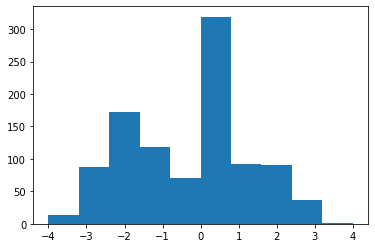

In [168]:
plt.hist(polaritat_tweets)

Sin tener en cuenta el valor 0, ya que representará aquellos tweets con ninguna palabra sin polaridad, podemos observar cómo tenemos bastante más tweets con un sentimiento negativo que positivo. Parece bastante razonable teniendo en cuenta la situación actual de la guerra en Ucrania.

### Ejercicio 8

**Ahora aplicamos un documento similar a AFINN-111 pero para emojis para extraer la polaridad de los tweets analizados que contengan emojis.**

In [117]:
import json
import codecs

data = json.load(codecs.open('emoji-polarity.txt', 'r', 'utf-8-sig'))
data["emojis"][1]['emoji']

'😠'

Para analizar la polaridad teniendo en cuenta los emojis haremos algo similar al anterior ejercicio.

Primero debemos volver a tratar los tweets para eliminar caracteres que no queremos, pero manteniendo los emojis.

Limpiamos los tweets.

In [170]:
clean_text_emojis = []
count = 0
aux = ""
for count in range(len(text_tweets)):
    aux = re.sub(url_pattern, '', text_tweets[count])
    aux = re.sub(user_pattern, '', aux)
    aux = aux.replace("#", "")
    clean_text_emojis.append(aux.lower())
    count += 1

# Comprobamos algunos tweets que hemos visto que tienen emojis
clean_text_emojis[62:65]

['a russian soldier spotted our drone and started running away, aventually leading us to his positions that were effectively targeted by our artillery as a result.\n\ni added the sound for dramatic flare. \n\nglory to ukraine 🇺🇦✊🏻 ',
 'our call for help is for a very specific problem….you’ve done amazingly since last night’s video but we need more! 🇺🇦 ukraine animals affected include shelters like borodyanka &amp; those who’s families have been killed, such as those seen in devastated bucha. help us help them ❤️ ',
 ' in the meantime scholz in germany is doing everything he can to stop the delivery of weapons to ukraine.\n']

--------------------

Vemos que se mantienen los emojis 🇺🇦✊🏻 y ❤️. Pasamos ahora a tokenizar ese resultado.

Para filtrar estos tokens eliminaremos stopwords y algunos caracteres especiales, pero siempre comprobando que no eliminamos los emojis.

Hemos decidido eliminar sólo estos caracteres especiales y no hacer el filtrado con *isalnum()* como hemos hecho en el ejercicio anterior, ya que si lo hacíamos eliminábamos los emojis. Es posible que tengamos algo más de ruido que con los tokens anteriores.

In [171]:
tokens_tweets_emojis = []
special_characters = [".","``","`", ",","''",":",";","=","-","*","’", "‘", "...", ".."]
for tweet in clean_text_emojis:
    tokens = word_tokenize(tweet)   
    #tokens = [c for c in tokens if c.isalnum()]
    tokens = [c for c in tokens if c not in special_characters]
    tokens = [c for c in tokens if not c.startswith("'")]
    tokens = [c for c in tokens if c not in stopwords]
    tokens_tweets_emojis.append(tokens)

# Comprobamos algunos tweets que hemos visto que tienen emojis
print(len(tokens_tweets_emojis))
tokens_tweets_emojis[62:65]

1000


[['russian',
  'soldier',
  'spotted',
  'drone',
  'started',
  'running',
  'away',
  'aventually',
  'leading',
  'us',
  'positions',
  'effectively',
  'targeted',
  'artillery',
  'result',
  'added',
  'sound',
  'dramatic',
  'flare',
  'glory',
  'ukraine',
  '🇺🇦✊🏻'],
 ['call',
  'help',
  'specific',
  'problem….you',
  'done',
  'amazingly',
  'since',
  'last',
  'night',
  'video',
  'need',
  '!',
  '🇺🇦',
  'ukraine',
  'animals',
  'affected',
  'include',
  'shelters',
  'like',
  'borodyanka',
  '&',
  'amp',
  'families',
  'killed',
  'seen',
  'devastated',
  'bucha',
  'help',
  'us',
  'help',
  '❤️'],
 ['meantime',
  'scholz',
  'germany',
  'everything',
  'stop',
  'delivery',
  'weapons',
  'ukraine']]

Vemos que tenemos unos resultados bastante aceptables y hemos mantenido los emojis.

Pasamos ahora a calcular la polaridad. Lo que haremos será lo mismo que en el ejercicio anterior pero teniendo en cuenta también la polaridad del emoji.

In [172]:
polaritat_tweets_emojis = []
for token in tokens_tweets:
    words_polarization = 0
    sum_polarization = 0
    for t in token:
        if t in afinn_df['word'].unique():
            words_polarization +=1
            sum_polarization += afinn_df['polarization'][afinn_df['word'] == t].values[0]
            
        # Añadimos este bucle for donde comprobamos si hay algún emoji de nuestra lista y calculamos su polaridad
        else:
            for emoji in data["emojis"]:
                if(emoji["emoji"] in t):
                    words_polarization +=1
                    sum_polarization += emoji["polarity"]
    
    mean_polarization = (sum_polarization/words_polarization) if words_polarization > 0 else 0
    polaritat_tweets_emojis.append(mean_polarization)

Comprobamos.

In [173]:
print(len(polaritat_tweets_emojis))
print(polaritat_tweets_emojis[0:10])

1000
[0, 0, 2.0, 0, -2.0, -3.0, 2.0, 2.0, -3.0, 0]


Comparemos ahora los dos histogramas para ver cómo ha influenciado en la polaridad tener en cuenta a los emojis.

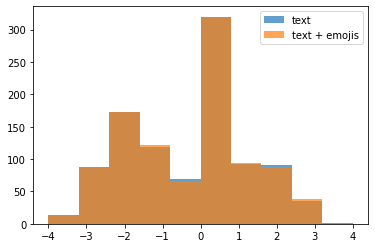

In [181]:
plt.hist(polaritat_tweets, alpha=0.7, label='text')
plt.hist(polaritat_tweets_emojis, alpha=0.7, label='text + emojis')
plt.legend(loc='upper right')
plt.show()

Con los dos histogramas apilados no parece haber muchas diferencias.

Vemos la polaridad teniendo en cuenta sólo los emojis y contamos los tweets que están utilizando.

In [186]:
polaritat_tweets_emojis = []
count_emojis = 0
for token in tokens_tweets:
    words_polarization = 0
    sum_polarization = 0
    for t in token:
        for emoji in data["emojis"]:
            if(emoji["emoji"] in t):
                words_polarization +=1
                sum_polarization += emoji["polarity"]
                count_emojis +=1
    
    # Guardamos solos aquellos tweets que tengan algún emoji
    if(words_polarization > 0):
        mean_polarization = (sum_polarization/words_polarization) if words_polarization > 0 else 0
        polaritat_tweets_emojis.append(mean_polarization)

In [187]:
print(len(polaritat_tweets_emojis))
print(count_emojis)

57
77


Tenemos sólo 57 tweets en los que hay algún emoji de nuestra lista y de estos 57 hay que tienen más de uno. Esto explica por qué no vemos grandes diferencias en la distribución de la polaridad de todos los tweets. Está afectando a muy pocos mensajes.

Podemos observar el histograma de los emojis para ver qué tendencia siguen si sólo tenemos en cuenta estos tweets.

(array([ 1.,  6.,  2.,  4.,  0.,  2., 17., 10., 13.,  2.]),
 array([-4. , -3.2, -2.4, -1.6, -0.8,  0. ,  0.8,  1.6,  2.4,  3.2,  4. ]),
 <BarContainer object of 10 artists>)

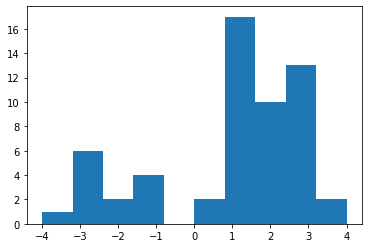

In [188]:
plt.hist(polaritat_tweets_emojis)

El total de los datos es muy pequeño, pero podemos observar una gran diferencia respecto a la polaridad teniendo en cuenta sólo las palabras. Parece que la tendencia de los tweets donde existen emojis suele ser de una polaridad mucho más positiva.

# 3. Clasificación

Volveremos a utilizar los comentarios de hoteles para crear un clasificador de opiniones a good y bad.

In [3]:
hotel_opinions_data = pd.read_csv('hotel_opinions_data.csv')

# Creamos una nueva etiqueta donde agrupamos por opiniones buenas o malas

hotel_opinions_data["sentiment"] = hotel_opinions_data["Reviewer_Score"].apply(lambda x: "good" if x < 5 else "bad")

# Seleccionamos las columnas más relevantes

hotel_opinions_data = hotel_opinions_data[["review","reviewer_nationality", "sentiment"]]
hotel_opinions_data.head()

review reviewer_nationality  \
0                            l ascenseur No Positive             Lebanon    
1   Having to log in each day with a new login an...           Australia    
2   the TV is crazy the hotel host a lot of natio...               Qatar    
3   No complaints  Excellent location very helpfu...             Ireland    
4   We booked an executive room with super king b...      United Kingdom    

  sentiment  
0       bad  
1       bad  
2       bad  
3       bad  
4       bad

## Ejercicio 9

**Vectorizamos las opiniones con el tf.idf vectorizer y entrena el clasificador usando la logistic regresion. Presentaremos una muestra de predicción de opiniones con este clasificador**

Para crear y entrenar a este clasificador seguiremos un procedimiento similar al ejercicio 3 de la primera práctica.

Importamos las librerías necesarias.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Ahora obtenemos las opiniones y las etiquetas.

In [6]:
opinions = hotel_opinions_data['review'].tolist()

# Comprobamos
opinions[0:5]

[' l ascenseur No Positive',
 ' Having to log in each day with a new login and password to use the wifi   The Kensington Close Hotel was in a fantastic location 5 mins from High St Kensington station Room was extremely clean with a very comfortable bed Email communication with the hotel was prompt and helpful Staff extremely helpful and polite Both still and sparkling bottled water provided free of charge and replenished daily Good wifi ',
 ' the TV is crazy the hotel host a lot of nationalities and all what they have it italian and 2 english news channels  in general it was ok',
 ' No complaints  Excellent location very helpful staff We had a beautiful room with a large balcony and really enjoyed our short stay We have stayed at the hotel many times and we will definetly be back again ',
 ' We booked an executive room with super king bed which took up most of the room Only two teabags and 4 little pots of milk For two of us Bar drinks expensive 22 for vodka and lime pot tea and small 

In [7]:
etiquetes = hotel_opinions_data['sentiment'].tolist()

# Comprobamos
etiquetes[0:5]

['bad', 'bad', 'bad', 'bad', 'bad']

En el siguiente paso vectorizaremos las opiniones.

In [8]:
# Creamos el vectorizador
vectorizer = TfidfVectorizer()

# Vectorizamos la lista de strings
X = vectorizer.fit_transform(opinions)

# Convertimos el resultado
matrix = X.toarray()

# Comprobamos
print(len(matrix))
print(matrix)

1000
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Una vez hemos vectorizado las opiniones con tf.idf pasamos a dividir los datos y entrenar el modelo. Utilizaremos el 80% para el entrenamiento y el 20% para test.

In [9]:
X_train, X_test, y_train, y_test  = train_test_split(matrix, etiquetes, train_size=0.80, random_state=123)

# Comprobamos
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

800
200
800
200


Entrenamos el modelo.

In [10]:
classifier = LogisticRegression()
model = classifier.fit(X=X_train, y=y_train)

En este punto ya tenemos un modelo para detectar opiniones buenas y malas.

Predecemos con los datos de test y vemos algunos resultados.

In [11]:
y_pred = model.predict(X_test)

# Comprobamos algunas etiquetas obtenidas y comprobamos con el valor real
print(y_pred[0:10])
print(y_test[0:10])

['bad' 'bad' 'bad' 'bad' 'bad' 'bad' 'bad' 'bad' 'good' 'bad']
['bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'good', 'bad']


Estas 10 primeras opiniones han acertado todas. En el siguiente ejercicio veremos mejor lo bien que se comporta este modelo.

# 4. Evaluación: Comparación de modelos

## Ejercicio 10

<ul>
<li>Vectoriza las opiniones con el tf.idf vectorizer, pero transforma las opiniones de forma que las palabras estén lematizadas y no haya stopwords.</li>
<li>Entrena el clasificador con estos vectores usando la logística regresión y compara los resultados con los resultados del clasificador del ejercicio 9.</li>
<li>¿Crees que cambiando el método de entrenamiento -por ejemplo, SVM- se habrían obtenido resultados significativamente diferentes o, crees, en cambio, que la transformación de las opiniones es el factor significativo? Razona las respuestas</li>
</ul>

**Vectoriza las opiniones con el tf.idf vectorizer, pero transforma las opiniones de forma que las palabras estén lematizadas y no haya stopwords.**

Importamos las librerías necesarias.

In [12]:
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn import metrics

Para obtener las opiniones lematizadas debemos tokenizarlas y después aplicar la función *lemmatize()*.

In [13]:
lem = WordNetLemmatizer()

In [14]:
tokens_op_lema = []
for op in opinions:
    tokens = word_tokenize(op.lower())
    tokens = [c for c in tokens if c not in stopwords]
    tokens = [lem.lemmatize(c) for c in tokens]
    tokens_op_lema.append(tokens)

# Comprobamos
print(tokens_op_lema[0:3])

[['l', 'ascenseur', 'positive'], ['log', 'day', 'new', 'login', 'password', 'use', 'wifi', 'kensington', 'close', 'hotel', 'fantastic', 'location', '5', 'min', 'high', 'st', 'kensington', 'station', 'room', 'extremely', 'clean', 'comfortable', 'bed', 'email', 'communication', 'hotel', 'prompt', 'helpful', 'staff', 'extremely', 'helpful', 'polite', 'still', 'sparkling', 'bottled', 'water', 'provided', 'free', 'charge', 'replenished', 'daily', 'good', 'wifi'], ['tv', 'crazy', 'hotel', 'host', 'lot', 'nationality', 'italian', '2', 'english', 'news', 'channel', 'general', 'ok']]


Ahora juntamos cada lista de tokens en una sola string para después vectorizarlas.

In [15]:
opinions_lema = [" ".join(op) for op in tokens_op_lema]

# Comprobamos
opinions_lema[0:3]

['l ascenseur positive',
 'log day new login password use wifi kensington close hotel fantastic location 5 min high st kensington station room extremely clean comfortable bed email communication hotel prompt helpful staff extremely helpful polite still sparkling bottled water provided free charge replenished daily good wifi',
 'tv crazy hotel host lot nationality italian 2 english news channel general ok']

A partir de este punto, ya podemos seguir los pasos anterior.

Vectorizamos.

In [16]:
vectorizer_lema = TfidfVectorizer()
X_lema = vectorizer.fit_transform(opinions_lema)

# Convertimos el resultado
matrix_lema = X_lema.toarray()

# Comprobamos
print(len(matrix_lema))
print(matrix_lema)

1000
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**Entrena el clasificador con estos vectores usando la logística regresión y compara los resultados con los resultados del clasificador del ejercicio 9.**

Partimos los datos en entrenamiento y test.

In [17]:
X_train_lema, X_test_lema, y_train_lema, y_test_lema  = train_test_split(matrix_lema, etiquetes, train_size=0.80, random_state=123)

# Comprobamos
print(len(X_train_lema))
print(len(X_test_lema))
print(len(y_train_lema))
print(len(y_test_lema))

800
200
800
200


Entrenamos el modelo.

In [18]:
classifier_lema = LogisticRegression()
model_lema = classifier_lema.fit(X=X_train_lema, y=y_train_lema)

In [19]:
y_pred_lema = model_lema.predict(X_test_lema)

# Comprobamos algunas etiquetas obtenidas y comprobamos con el valor real
print(y_pred_lema[0:10])
print(y_test_lema[0:10])

['bad' 'bad' 'bad' 'bad' 'bad' 'bad' 'bad' 'bad' 'bad' 'bad']
['bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'good', 'bad']


Parece que al lematizar y quitar las stopwords hemos obtenido un resultado peor en estas 10 primeras opiniones, pero ¿será ésta la tendencia del nuevo modelo?

Para comparar ambos modelos podemos utilizar la matriz de confusión y las métricas asociadas.

Definimos una pequeña función para mostrar la matriz de confusión con las etiquetas.

In [20]:
def print_cofusion_matrix(test, pred, labels):
    a =  metrics.confusion_matrix(test, pred)
    print(pd.DataFrame(a, index=labels, columns=labels))

**Sin lematizar**

In [21]:
print_cofusion_matrix(y_test, y_pred, ['bad','good'])

      bad  good
bad   116     2
good   46    36


In [22]:
print(metrics.classification_report(y_test, y_pred, labels=['bad','good']))

              precision    recall  f1-score   support

         bad       0.72      0.98      0.83       118
        good       0.95      0.44      0.60        82

    accuracy                           0.76       200
   macro avg       0.83      0.71      0.71       200
weighted avg       0.81      0.76      0.73       200



In [23]:
116/(116+2)

0.9830508474576272

**Lematizando**

In [24]:
print_cofusion_matrix(y_test_lema, y_pred_lema, ['bad','good'])

      bad  good
bad   114     4
good   48    34


In [25]:
print(metrics.classification_report(y_test_lema, y_pred_lema, labels=['bad','good']))

              precision    recall  f1-score   support

         bad       0.70      0.97      0.81       118
        good       0.89      0.41      0.57        82

    accuracy                           0.74       200
   macro avg       0.80      0.69      0.69       200
weighted avg       0.78      0.74      0.71       200



Si recordamos estas métricas tenemos:
- *precision*:
    - Porcentaje de opiniones que el sistema ha clasificado correctamente.
    - precisión (P) = $\frac{VP}{VP+FP}$

- *recall*:
    - Proporción de casos positivos correctamente clasificados.
    - recall (R) = $\frac{VP}{VP+FN}$

- *f1-score*:
    - Relación entre *precision* y *recall*. Nos devolverá un valor entre 0 y 1. Cuanto más cercano a 1 significará que mejor es el modelo. Podemos comprobar que tanto uno como otro funcionan mejor para clasificar opiniones malas que buenas.
    - f1 = $\frac{2PR}{P+R}$

- *support*: total de opiniones clasificadas como *bad* y como *good*.

Por lo general podemos comprobar que hemos obtenido unas métricas muy parecidas tanto en un modelo como en el otro, con un pequeño empeoramiento en el modelo con las opiniones lematizadas, aunque este empeoramiento ha sido de sólo dos errores más. La muestra es bastante pequeña, por lo que no podemos decir que las diferencias sean significativas.

**¿Crees que cambiando el método de entrenamiento -por ejemplo, SVM- se habrían obtenido resultados significativamente diferentes o, crees, en cambio, que la transformación de las opiniones es el factor significativo? Razona las respuestas**

Como hemos visto, no hemos observado diferencias significativas entre los dos modelos, aunque podríamos pensar que al lematizar y quitar las stopwords hubiésemos obtenido alguna mejora. El cuerpo de entrenamiento es bastante pequeño, podría ser buena idea entrenar con más datos y ver si seguimos teniendo los mismos resultados.

En lo que se refiere a aplicar otro modelo como SVM podríamos conseguir un modelo mejor o no. Lo podemos comprobar fácilmente con la librería LinearSVC de Python.

In [26]:
from sklearn.svm import LinearSVC

In [27]:
classifier_svm = LinearSVC()
svm_model = classifier_svm.fit(X=X_train, y=y_train)
y_pred_svm = svm_model.predict(X_test)

# Comprobamos
print_cofusion_matrix(y_test, y_pred_svm, ['bad','good'])
print("\n")
print(metrics.classification_report(y_test, y_pred_svm, labels=['bad','good']))

      bad  good
bad   104    14
good   25    57


              precision    recall  f1-score   support

         bad       0.81      0.88      0.84       118
        good       0.80      0.70      0.75        82

    accuracy                           0.81       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.81      0.80       200



In [28]:
classifier_svm = LinearSVC()
svm_model = classifier_svm.fit(X=X_train_lema, y=y_train_lema)
y_pred_svm_lema = svm_model.predict(X_test_lema)

# Comprobamos
print_cofusion_matrix(y_test_lema, y_pred_svm_lema, ['bad','good'])
print("\n")
print(metrics.classification_report(y_test, y_pred_svm_lema, labels=['bad','good']))

      bad  good
bad   104    14
good   26    56


              precision    recall  f1-score   support

         bad       0.80      0.88      0.84       118
        good       0.80      0.68      0.74        82

    accuracy                           0.80       200
   macro avg       0.80      0.78      0.79       200
weighted avg       0.80      0.80      0.80       200



SVM es un algoritmo muy utilizado en el reconocimiento de textos, puede dar un mejor resultado como ha sido el caso. Tenemos menos fallos de clasificación totales. Un poco más para malas opiniones pero bastante menos para opiniones buenas.

Aunque tenemos un mejor resultado con SVM, por estos problemas suele ser mejor idea tener *features* mejores e incluso añadir otras nuevas. Por ejemplo lematizando y eliminando *stopwords* estaremos reduciendo el ruido y normalizando el texto para asociar palabras que nos interesa tener como una sola (por ejemplo, plurales y singulares). También, teniendo en cuenta el tipo de problema, podríamos crear una nueva *feature* con la polarización de la opinión. Si la polarización fuese negativa, es muy probable que la puntuación del cliente haya sido mala.